# Árvore para atributos contínuos

In [1]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:,2:], iris.target

# Calculo de Impureza (customizavel)

In [2]:
#Gini
def impurezaGini(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

#Entropy
def impurezaEntropia(y): # https://quantdare.com/decision-trees-gini-vs-entropy/
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = - sum(probabilidades * np.log2(probabilidades))
    return result

def impureza(y,isGini=True): #alterar o True para False, para ir no Entropy
    if isGini is True:
        return impurezaGini(y)
    else:
        return impurezaEntropia(y)
        
ytmp = y[:]
valor = impureza(ytmp,True)
print("valor: ",valor)
valor = impureza(ytmp,False)
print("valorEntropy: ",valor)

valor:  0.6666666666666667
valorEntropy:  1.584962500721156


# Arvore do Video

In [3]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores

def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza
    

def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]
    

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

print(impurezaValor(X[:,0], y, 2.5))
print(melhorValor(X[:,0], y))
print(melhorCaracteristica(X,y))

(0.3333333333333333, 0.5, 0.0)
(2.475, 0.3333333333333333)
(0, 2.475, 0.3333333333333333)


# Arvore Alterada

In [4]:
def piorValor(x, y): #posso considerar isso uma heuristica? pegar a maior impureza
    result = None
    maiorImpureza = float('-inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal > maiorImpureza:
            maiorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores > impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, maiorImpureza
    

def piorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = piorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

class ArvoreAlterada(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = piorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = ArvoreAlterada()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = ArvoreAlterada()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

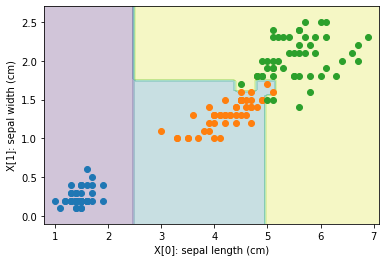

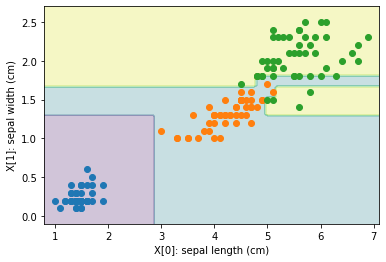

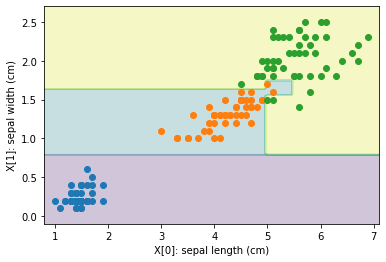

In [5]:
def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()


plotDecisao(Arvore(), X, y)
plotDecisao(ArvoreAlterada(), X, y)
plotDecisao(DecisionTreeClassifier(), X, y)

In [6]:
from sklearn.model_selection import cross_validate
scores = cross_validate(Arvore(), X, y)
scoresAlterada = cross_validate(ArvoreAlterada(), X, y)
scoresSklearn = cross_validate(DecisionTreeClassifier(), X, y)

print("Video:",scores['test_score'], np.mean(scores['test_score']))
print("Alterada:",scoresAlterada['test_score'], np.mean(scoresAlterada['test_score']))
print("sklearn:",scoresSklearn['test_score'], np.mean(scoresSklearn['test_score']))



C:\Users\luizg\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\luizg\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Video: [0.98039216 0.94117647 0.95833333] 0.9599673202614379
Alterada: [0.98039216 0.92156863 0.9375    ] 0.9464869281045751
sklearn: [0.98039216 0.92156863 0.97916667] 0.960375816993464


C:\Users\luizg\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
DBs = [
	pd.read_csv("water_potability.csv"),
	pd.read_csv("sobar-72.csv"),
	pd.read_csv("winequalityN.csv")
	]

for db in DBs:
	db = db.dropna()
	data = db.copy()
	X, y = data.iloc[:,:-1], data.iloc[:,-1]
	
	# print(X.shape, y.shape)
	# print(db.head())

	modelo = Arvore()
	modelo.fit(X,y)
	ypred = modelo.predict(X)
	scores = cross_validate(Arvore(), X, y)
	print("modelo Video:",np.mean(scores['test_score']))

	modelo = ArvoreAlterada()
	modelo.fit(X,y)
	ypred = modelo.predict(X)
	scores = cross_validate(ArvoreAlterada(), X, y)
	print("modelo Proprio:",np.mean(scores['test_score']))

	modelo = DecisionTreeClassifier()
	modelo.fit(X,y)
	ypred = modelo.predict(X)
	scores = cross_validate(DecisionTreeClassifier(), X, y)
	print("modelo Sklearn:",np.mean(scores['test_score']))

TypeError: '(slice(None, None, None), 0)' is an invalid key

Escrever um paragrafo expondo minha interpretação dos resultados obtidos

Corrigir o erro: '(slice(None, None, None), 0)' is an invalid key